# Выбор локации для скважины

Нужно решить, где бурить новую скважину.

Имеются пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Нужно построить модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Также нужно проанализировать возможную прибыль и риски техникой *Bootstrap.*

## Загрузка и подготовка данных

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import make_scorer, mean_absolute_error, mean_squared_error, r2_score
import numpy as np
from scipy import stats as st
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

In [2]:
data_0 = pd.read_csv('datasets/geo_data_0.csv')
data_1 = pd.read_csv('datasets/geo_data_1.csv')
data_2 = pd.read_csv('datasets/geo_data_2.csv')

## Описание данных

f0, f1, f2 — три признака точек (неважно, что они означают, но сами признаки значимы);

In [3]:
data_0.head()

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


In [4]:
data_1.head()

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


In [5]:
data_2.head()

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


Для начала любопытно посмотреть на целевой признак в регионах "глазами".

In [6]:
# Функция для вычисления перцентиля
def get_percentile(df, column_name, percentile_rank):
    
    # Удалим NaN в столбце, отсортируем df, сбросим индексы
    try:
        # Если на входе - dataframe
        df = df.dropna(subset=[column_name]).sort_values(by=column_name).reset_index()
    except:
        # Если на входе - series
        df = df.dropna().sort_values().reset_index()
    # Найдём индекс перцентиля
    index = (len(df.index)-1) * percentile_rank / 100.0
    index = int(index)
    value = df.at[index, column_name]
    # Вернём элемент с этим индексом
    return value

In [7]:
# Функция для вычисления интерквартильного размаха.
def interquartile_range(df, column_name):
    
    p75 = get_percentile(df, column_name, 75)  # 75-й перцентиль
    p25 = get_percentile(df, column_name, 25)  # 25-й перцентиль
    iqr = p75 - p25  # интерквартильный размах
    return iqr

In [8]:
# Функция для вычисления левого уса.
def left_mustache(df, column_name):
    p25 = get_percentile(df, column_name, 25)
    iqr = interquartile_range(df, column_name)
    p0 = get_percentile(df, column_name, 0)
    if p25 - iqr*1.5 < p0:
        return (p0)
    return(p25 - iqr*1.5)

In [9]:
# Функция для вычисления правого уса
def right_mustache(df, column_name):
    p75 = get_percentile(df, column_name, 75)
    iqr = interquartile_range(df, column_name)
    p100 = get_percentile(df, column_name, 100)
    if p75 + iqr*1.5 > p100:
        return (p100)
    return(p75 + iqr*1.5)

In [10]:
# Функция для построения гистограммы по значениям, входящим в ящик с усами.
def box_mustache_hist(df, column_name, bins, title=False):
    
    # Отсортируем df, сбросим индексы
    df = df.sort_values(by=column_name).reset_index()
    split = df.loc[(df.loc[:, column_name] >= left_mustache(df, column_name))\
                  &(df.loc[:, column_name] <= right_mustache(df, column_name))][column_name]
    plt.figure(figsize=(9,5))
    plt.hist(split, bins=bins)
    if title == False:
        plt.title(column_name)
    else:
        plt.title(title)
    # Вертикальные линии для каждого перцентиля
    plt.axvline(get_percentile(df, column_name, 25), linestyle='--', color='red')
    plt.axvline(get_percentile(df, column_name, 50), linestyle='-',  color='red')
    plt.axvline(get_percentile(df, column_name, 75), linestyle='--', color='red')
    plt.show()
    print('Среднее значение: ', round(df[column_name].mean(),2))
    print('Стандартное отклонение: ', round(df[column_name].std(),2))
    print('Медиана: ', get_percentile(df, column_name, 50))

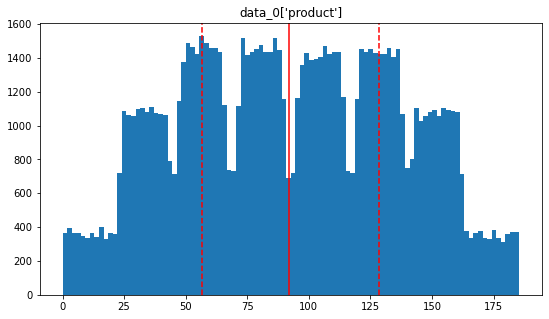

Среднее значение:  92.5
Стандартное отклонение:  44.29
Медиана:  91.84963194547692


In [11]:
box_mustache_hist(data_0, 'product', 100, "data_0['product']")

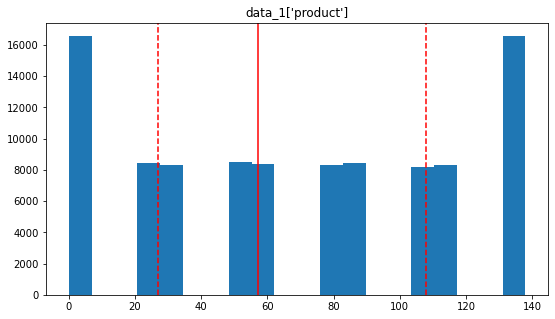

Среднее значение:  68.82
Стандартное отклонение:  45.94
Медиана:  57.08562464628662


In [12]:
box_mustache_hist(data_1, 'product', 20, "data_1['product']")

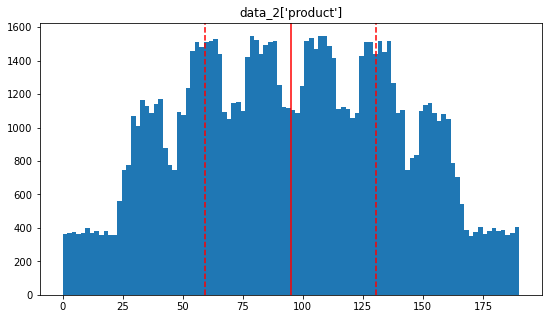

Среднее значение:  95.0
Стандартное отклонение:  44.75
Медиана:  94.92547018881879


In [13]:
box_mustache_hist(data_2, 'product', 100, "data_2['product']")

Данные в регионе 1 подозрительно отличаются. Бросается в глаза большое количество абсолютно одинаковых значений целевого признака.

## Обучение и проверка модели

Сохраним имена признаков в переменной.

In [14]:
features_list = ['f0','f1','f2']

In [15]:
# Функция возвращает features и target для датафрейма
def xy_prepare(df, features_list, target_name):
    features = df[features_list]
    target = df[target_name]
    return features, target

Создадим сетку гиперпараметров для линейной регрессии.

In [16]:
param_grid = {'fit_intercept': [False, True],
              'normalize': [False, True],
             'n_jobs': [-1, None]}  
param_grid

{'fit_intercept': [False, True],
 'normalize': [False, True],
 'n_jobs': [-1, None]}

Используем мтод GridSearchCV для выбора лучшей модели.

Преимущества этого метода:

- использование кросс-валидации,
- подбор гиперпараметров,
- выбор лучшей модели по заданной метрике.

In [17]:
# Функция возвращает предсказания лучшей модели и target_valid
def best_LR_model(df, features_list, target_name, param_grid, cv, refit):
    features, target = xy_prepare(df, features_list, target_name)
    features_train, features_valid, target_train, target_valid = \
        train_test_split(features, target, test_size=0.25, random_state=12345)
    
    pd.options.mode.chained_assignment = None
    scaler = StandardScaler()
    scaler.fit(features_train[features_list])
    features_train.loc[:,features_list] = scaler.transform(features_train.loc[:,features_list])
    features_valid.loc[:,features_list] = scaler.transform(features_valid.loc[:,features_list])
       
    scoring = {'RMSE': make_scorer(mean_squared_error), 
               'MAE': make_scorer(mean_absolute_error),
               'R2': make_scorer(r2_score)}
    model = LinearRegression()
    grid = GridSearchCV(model, 
                        param_grid, 
                        cv=cv, 
                        #verbose = 3, 
                        refit=refit, 
                        scoring=scoring) 
    grid_result = grid.fit(features_train, target_train)
    best_model = grid.best_estimator_
    best_score = grid_result.best_score_
    if refit == 'RMSE':
        best_score = best_score**0.5
    best_params = grid.best_params_
    predictions_valid = pd.Series(best_model.predict(features_valid), index=features_valid.index)
    RMSE = mean_squared_error(target_valid, predictions_valid)**0.5
    print(refit,"Best: %f using %s" % (best_score, best_params))
    print("\t Mean Prediction: {:.3f}".format(predictions_valid.mean()))
    print("\t RMSE: {:.3f}".format(RMSE))
    return(best_model, predictions_valid, target_valid)

Сохраним в переменных лучшие модели по коэффиценту детерминизации для каждого региона:

In [18]:
model_0, predicted_valid_0, target_valid_0 = best_LR_model(data_0, features_list, 'product', param_grid, 5, 'R2')

R2 Best: 0.274087 using {'fit_intercept': True, 'n_jobs': -1, 'normalize': False}
	 Mean Prediction: 92.593
	 RMSE: 37.579


In [19]:
model_1, predicted_valid_1, target_valid_1 = best_LR_model(data_1, features_list, 'product', param_grid, 5, 'R2')

R2 Best: 0.999625 using {'fit_intercept': True, 'n_jobs': -1, 'normalize': False}
	 Mean Prediction: 68.729
	 RMSE: 0.893


In [20]:
model_2, predicted_valid_2, target_valid_2 = best_LR_model(data_2, features_list, 'product', param_grid, 5, 'R2')

R2 Best: 0.196482 using {'fit_intercept': True, 'n_jobs': -1, 'normalize': True}
	 Mean Prediction: 94.965
	 RMSE: 40.030


Для датасета `data_1` значение средней квадратичной ошибки меньше всего. Но и предсказанное среднее меньше. Регион 0 лучше по метрике R2, а среднее почти такое же, как у региона 2.

## Подготовка к расчёту прибыли

Условия задачи:

- Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).
- При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
- Бюджет на разработку скважин в регионе — 10 млрд рублей.
- При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
- После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.

Данные синтетические: детали контрактов и характеристики месторождений не разглашаются.

**Рассчитаем достаточный объём сырья для безубыточной разработки новой скважины.**

- Себестоимость разработки 200 скважин:

In [21]:
COST_PRICE = 10**10

- Стоимость одной тысячи баррелей:

In [22]:
BARREL1000 = 450*1000
print(BARREL1000, "рублей")

450000 рублей


- Стоимость разработки 1-й скважины:

In [23]:
HOLE_COST = COST_PRICE/200
print(HOLE_COST, "рублей")

50000000.0 рублей


- Объем сырья для безубыточной разработки одной скважины:

In [24]:
HOLE_PRODUCT_MIN = HOLE_COST/450000
print(HOLE_PRODUCT_MIN, "тысяч баррелей")

111.11111111111111 тысяч баррелей


- Суммарное количество сырья для безубыточной разработки:

In [25]:
print(HOLE_PRODUCT_MIN*200, "тысяч баррелей")

22222.222222222223 тысяч баррелей


Для безубыточной разработки новой скважины требуется, чтобы на одну скважину приходилось 111.11 тысяч баррелей.

In [26]:
i = 0
for product in [data_0['product'], data_1['product'], data_2['product']]:
    print("Регион", i)
    product_mean = product.mean()
    print("\t Средний запас в регионе: {:.3f}".format(product_mean), "тысяч баррелей")
    i += 1

Регион 0
	 Средний запас в регионе: 92.500 тысяч баррелей
Регион 1
	 Средний запас в регионе: 68.825 тысяч баррелей
Регион 2
	 Средний запас в регионе: 95.000 тысяч баррелей


Как видно из результатов, в каждом регионе средний запас сырья на скважину меньше, чем необходимо для безубыточной разработки новой скважины.

In [27]:
# Функция возвращает общую прибыль
def revenue (predicted_valid, target_valid, cost_price):
    
    model_top200_predictions = predicted_valid.sort_values(ascending=False).head(200)
    model_top200_target = target_valid[model_top200_predictions.index]
    
    proceeds = model_top200_target.sum()*BARREL1000
    
    revenue = proceeds - cost_price # Валовая прибыль
    
    return revenue

In [28]:
model_dict = pd.DataFrame({1: [predicted_valid_0, target_valid_0],
              2: [predicted_valid_1, target_valid_1],
             3: [predicted_valid_2, target_valid_2]})

На валидационной выборке модель показала следующие результаты:

In [29]:
i = 0
model_top200_revenue = []
for row in model_dict:
    print("Регион", i)
    model_top200_revenue.append(revenue(model_dict[row][0], model_dict[row][1], COST_PRICE))
    print("\tВаловая прибыль:  {:.0f}".format(revenue(model_dict[row][0], model_dict[row][1], COST_PRICE)), "рублей")
    i += 1

Регион 0
	Валовая прибыль:  3320826043 рублей
Регион 1
	Валовая прибыль:  2415086697 рублей
Регион 2
	Валовая прибыль:  2710349964 рублей


## Расчёт прибыли и рисков 

Посмотрим, как наши модели работают на всём объёме данных по каждому из регионов.
Сохраним предсказания в переменных.

In [30]:
data_0_features, data_0_target = xy_prepare(data_0, features_list, 'product')
data_0_predictions = pd.Series(model_0.predict(data_0_features), index=data_0_features.index)

data_1_features, data_1_target = xy_prepare(data_1, features_list, 'product')
data_1_predictions = pd.Series(model_1.predict(data_1_features), index=data_1_features.index)

data_2_features, data_2_target = xy_prepare(data_2, features_list, 'product')
data_2_predictions = pd.Series(model_2.predict(data_2_features), index=data_2_features.index)

In [31]:
# Функция возвращает средние значения прибылей, полученные bootstrap
state = np.random.RandomState(12345)
def bootstrap(target, predictions, n, volume, setpoint1, setpoint2):
    values = []
    loss = 0
    for i in range(volume):
    
        target_subsample = target.sample(n, replace=True, random_state=state) 
        probs_subsample = predictions[target_subsample.index]
        value = revenue(probs_subsample, target_subsample, COST_PRICE)
        if value < 0:
            loss +=1
        values.append(value)
        
    values = pd.Series(values)

    lower = values.quantile(setpoint1)
    upper = values.quantile(setpoint2)
    print('lower: {:.0f}'.format(lower))
    print('mean: {:.0f}'.format(values.mean()))
    print('upper: {:.0f}'.format(upper))
    print('risk: {:.2%}'.format(loss/len(values)) )
    return values

In [32]:
import seaborn as sns
# Функция строит распределение плотностей вероятности
def probability_density(series, column_name, title, setpoint1, setpoint2):
    plt.figure(figsize=(12,6))
    plt.title(title)
    sns.kdeplot(series, color='r', shade=True, label='ultra')
    plt.xlabel(column_name) 
    plt.ylabel('probability density')
    plt.axvline(series.quantile(setpoint1), linestyle='-', color='red')
    plt.axvline(series.mean(), linestyle='--', color='green')
    plt.axvline(series.quantile(setpoint2), linestyle='-', color='blue')
    plt.show()

lower: -160494317
mean: 386642504
upper: 998678751
risk: 8.20%


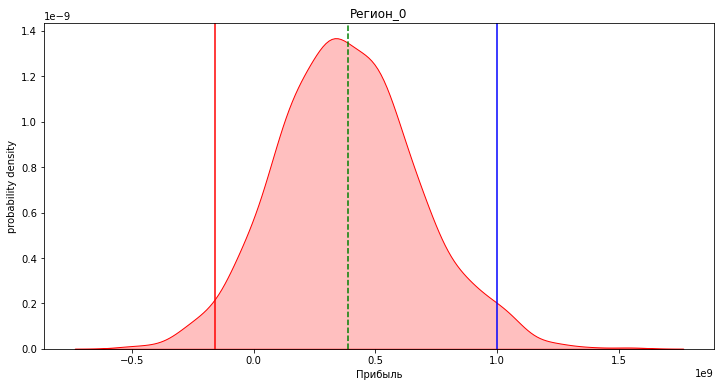

In [33]:
revenue_0_bootstraped = bootstrap(data_0_target, data_0_predictions, 500, 1000, 0.025, 0.975)
probability_density(revenue_0_bootstraped, 'Прибыль', 'Регион_0', 0.025, 0.975)

lower: 59532365
mean: 487596655
upper: 919413959
risk: 0.80%


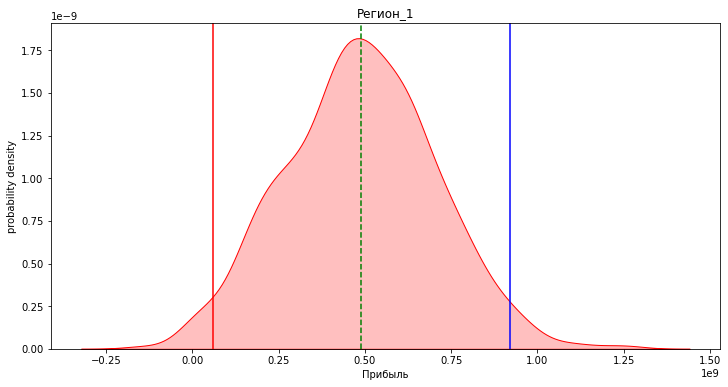

In [34]:
revenue_1_bootstraped = bootstrap(data_1_target, data_1_predictions, 500, 1000, 0.025, 0.975)
probability_density(revenue_1_bootstraped, 'Прибыль', 'Регион_1', 0.025, 0.975)

lower: -106542114
mean: 437313191
upper: 981639924
risk: 7.10%


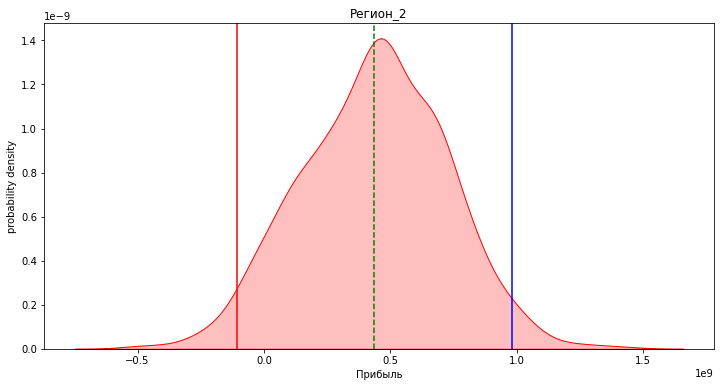

In [35]:
revenue_2_bootstraped = bootstrap(data_2_target, data_2_predictions, 500, 1000, 0.025, 0.975)
probability_density(revenue_2_bootstraped, 'Прибыль', 'Регион_2', 0.025, 0.975)

# Вывод

- Для региона 1 вероятность более высокой прибыли выше, при меньшем риске получить убыток менее 2.5%.

- Регионы 0 и 2 не подходят, т.к. в них риск убытка более 2.5%.